In [1]:
import torch
from xopt import Xopt
import yaml

YAML="""
xopt:
    dump_file: dump.yaml
generator:
    name: BayesianExploration
    n_initial: 5
    optim:
        num_restarts: 1
    acq:
        proximal_lengthscales: [1.5, 1.5]

evaluator:
    name: test_TNK
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""
yaml_output = yaml.safe_load(YAML)

In [2]:
X = Xopt(config=yaml_output)


In [3]:
X.step()

for i in range(5):
    print(f'step {i}')
    X.step()

step 0
step 1
step 2
step 3
step 4


In [4]:
X.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
1,1.502094,0.667893,dummy_constant,1.502094,0.667893,1.610696,1.032380,"[1, 2, 3]",False,
2,0.572451,2.419664,dummy_constant,0.572451,2.419664,5.266371,3.690358,"[1, 2, 3]",False,
3,0.183562,0.057912,dummy_constant,0.183562,0.057912,-0.980595,0.295575,"[1, 2, 3]",False,
4,2.947361,0.734817,dummy_constant,2.947361,0.734817,8.298840,6.044713,"[1, 2, 3]",False,
5,2.189334,1.233000,dummy_constant,2.189334,1.233000,5.348004,3.391138,"[1, 2, 3]",False,
6,1.556510,0.860757,dummy_constant,1.556510,0.860757,2.186266,1.246359,"[1, 2, 3]",False,
7,1.343819,0.798765,dummy_constant,1.343819,0.798765,1.510313,0.801291,"[1, 2, 3]",False,
8,1.212367,0.683675,dummy_constant,1.212367,0.683675,0.972609,0.541203,"[1, 2, 3]",False,
9,1.101007,0.695166,dummy_constant,1.101007,0.695166,0.787030,0.399299,"[1, 2, 3]",False,
10,1.056139,0.807727,dummy_constant,1.056139,0.807727,0.820050,0.403987,"[1, 2, 3]",False,


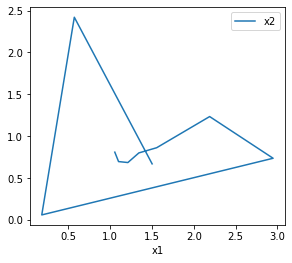

In [5]:
# plot results
ax = X.data.plot("x1","x2")
ax.set_aspect('equal')

C:\ProgramData\Miniconda3\envs\xopt\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


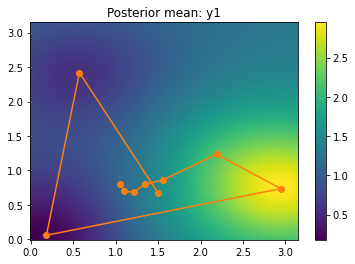

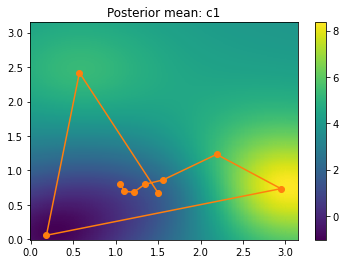

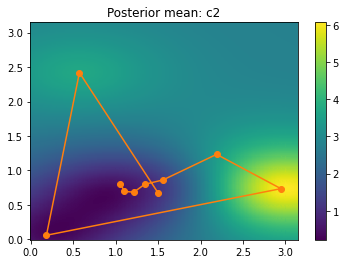

In [6]:
from matplotlib import pyplot as plt# plot model predictions
data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 200
x = torch.linspace(*bounds.T[0],n)
y = torch.linspace(*bounds.T[1],n)
xx,yy = torch.meshgrid(x,y)
pts = torch.hstack([ele.reshape(-1,1) for ele in (xx,yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    for i in range(mean.shape[-1]):
        fig,ax = plt.subplots()
        ax.plot(*data[["x1","x2"]].to_numpy().T,'o-C1')
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n,n))
        fig.colorbar(c)
        ax.set_title(f'Posterior mean: {outputs[i]}')


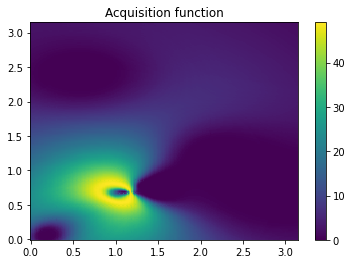

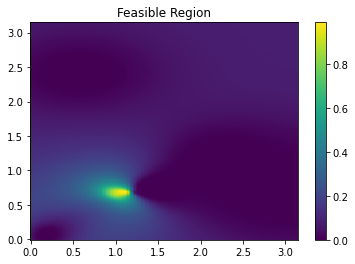

In [7]:
from xopt.generators.bayesian.utils import feasibility

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx,yy,acq.reshape(n,n))
    fig.colorbar(c)
    ax.set_title('Acquisition function')

    feas = feasibility(
        pts.unsqueeze(1),
        model,
        X.generator.sampler,
        X.vocs
    ).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx,yy,feas.reshape(n,n))
    fig2.colorbar(c)
    ax2.set_title('Feasible Region')